# Welch's Procedure

In [1]:
from __future__ import annotations

from agents.AgentsLoader import AgentsLoader
from system.InventoryEnv_Multi_Item import WarehouseEnv
from system.Inventory_Multi_Item import Warehouse
from system.Inventory_Multi_Item_S import Warehouse as Warehouse_S
from system.Item import Item
import matplotlib.pyplot as plt
from utils import generate_seeds
from tqdm import tqdm
import random
import simpy
import warnings
warnings.filterwarnings("error", category=RuntimeWarning)

### Settings

In [2]:
# Simulation time - 5 years
sim_time = 1_000

# Number of replications, same as number of seeds
n = 1000

# Define the items
item_1 = Item(
    id="1",
    description="Iphone 15",
    lead_time=lambda: random.uniform(15, 30),
    demand_inter_arrival_time=lambda: random.expovariate(lambd=1 / 3),
    demand_distribution=[[1, 2, 3, 4], [1 / 3, 1 / 6, 1 / 6, 1 / 3]],
    s_min=20,
    s_max=42
)
item_2 = Item(
    id="2",
    description="AirPods Pro",
    lead_time=lambda: random.uniform(6, 21),
    demand_inter_arrival_time=lambda: random.expovariate(lambd=1 / 3),
    demand_distribution=[[1, 2, 3, 4], [1 / 3, 1 / 6, 1 / 6, 1 / 3]],
    s_min=6,
    s_max=27
)
items = [item_1, item_2]

# Inventory initial position
inventory_position_distribution_1 = lambda: random.uniform(-75, 75)
inventory_position_distribution_2 = lambda: random.uniform(-75, 75)

# Definizione dei seed
seeds = generate_seeds(n)

# Fixed cost
policy_fixed_costs = []

# Reinforcement Learning
rl_agent_list = ['a2c_mlp', 'dqn_mlp', 'ppo_mlp']
rl_agent_costs = {
    'a2c_mlp': [],
    'dqn_mlp': [],
    'ppo_mlp': [],
}

## Running the simulation

Run each model n time. Store costs of each run.

In [3]:
# Reinforcement Learning Models
for rl_agent in rl_agent_list:
    for seed in tqdm(seeds):
        # Define Simpy environment
        env = simpy.Environment()
        # Define Warehouse
        w_simpy_env = Warehouse(
            id="Warehouse - Training",
            env=env,
            items=items,
            inventory_levels=[inventory_position_distribution_1, inventory_position_distribution_2],
            order_setup_cost=10,
            order_incremental_cost=3,
            holding_cost=1,
            shortage_cost=7
        )
        # Define Warehouse Gym Env
        w_gym_env = WarehouseEnv(
            warehouse=w_simpy_env,
            step_duration=1,  # 1 Day, add delay to process last cost
        )
        # Load best agent
        al = AgentsLoader(w_gym_env)
        agent = al.load_weight(model_id=rl_agent)
        obs, _ = w_gym_env.reset(seed=seed)
        for _ in range(sim_time):
            actions, _states = agent.predict(obs)
            obs, rewards, done, truncated, info = w_gym_env.step(actions)
        rl_agent_costs[rl_agent].append(w_gym_env.warehouse.daily_total_cost)
        w_gym_env.warehouse.reset_system_attributes()

100%|██████████| 1000/1000 [02:20<00:00,  7.10it/s]


In [4]:
# Policy fixed agent
print("Running policy fixed agent...")
for seed in tqdm(seeds):
    random.seed(seed)
    # Define Simpy environment
    env = simpy.Environment()
    # Define warehouse env
    w_simpy_env_S = Warehouse_S(
        id="Warehouse - Training",
        env=env,
        items=items,
        inventory_levels=[inventory_position_distribution_1, inventory_position_distribution_2],
        order_setup_cost=10,
        order_incremental_cost=3,
        holding_cost=1,
        shortage_cost=7
    )
    # Run policy fixed system for given amount of time
    w_simpy_env_S.env.run(until=sim_time)
    policy_fixed_costs.append(w_simpy_env_S.daily_total_cost)

Running policy fixed agent...


100%|██████████| 1000/1000 [00:30<00:00, 32.83it/s]


## Plot all results in order to look for mistakes

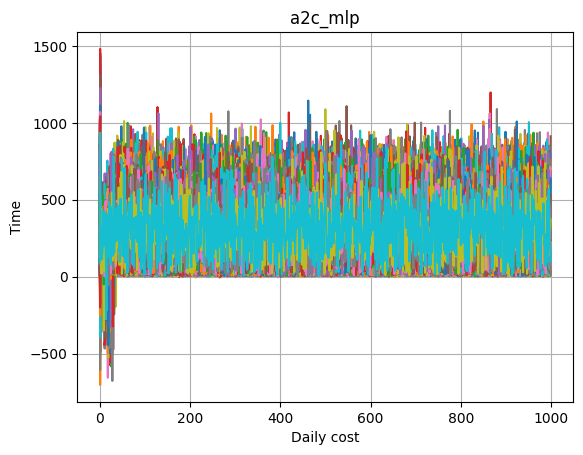

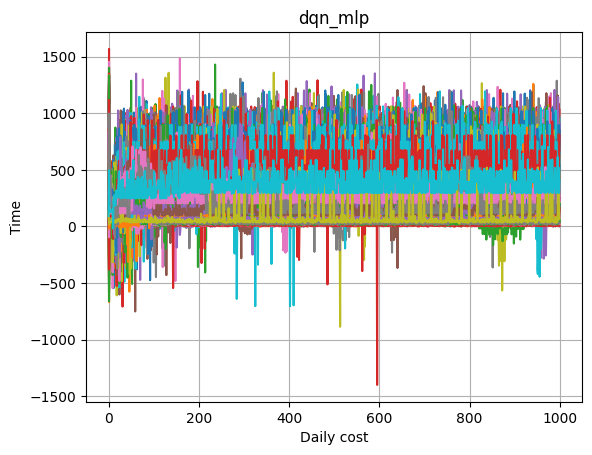

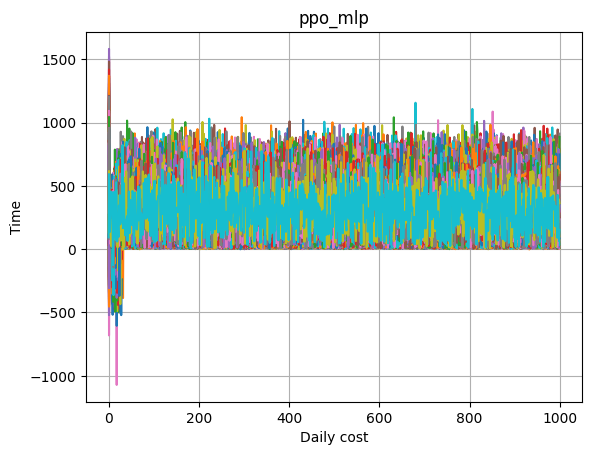

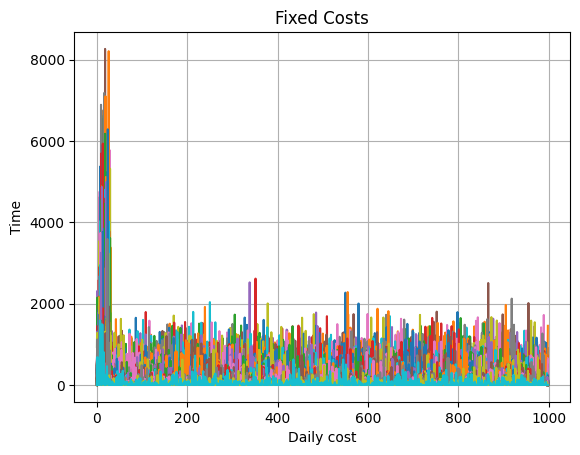

In [5]:
# Plot RL
for rl_agent in rl_agent_list:
    # Create a figure and axis
    fig, ax = plt.subplots()
    
    # Plot each list
    for ith_cost_history in rl_agent_costs[rl_agent]:
        ax.plot(ith_cost_history)
        
    # Set plot title and labels
    ax.set_title(rl_agent)
    ax.set_xlabel('Daily cost')
    ax.set_ylabel('Time')
    
    # Show plot with grid
    ax.grid(True)
    plt.show()


# Create a figure and axis
fig, ax = plt.subplots()

# Plot each list
for ith_cost_history in policy_fixed_costs:
    ax.plot(ith_cost_history)

# Set plot title and labels
ax.set_title('Fixed Costs')
ax.set_xlabel('Daily cost')
ax.set_ylabel('Time')

# Show plot with grid
ax.grid(True)
plt.show()

## Compute average and plot daily cost

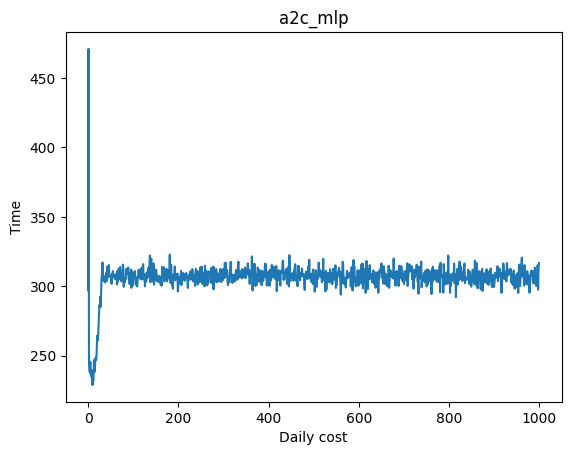

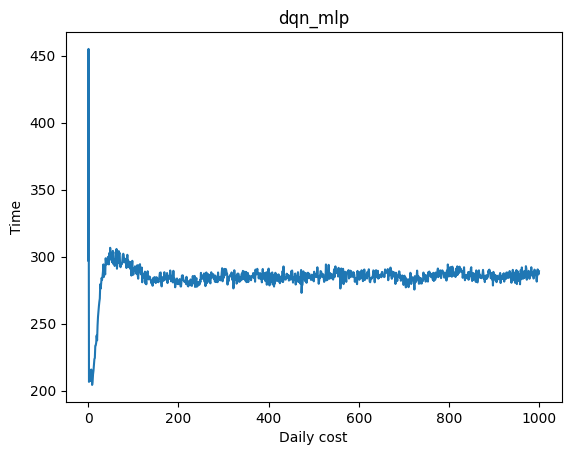

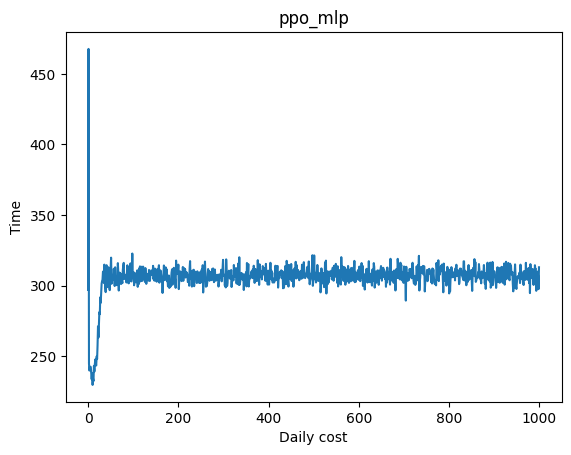

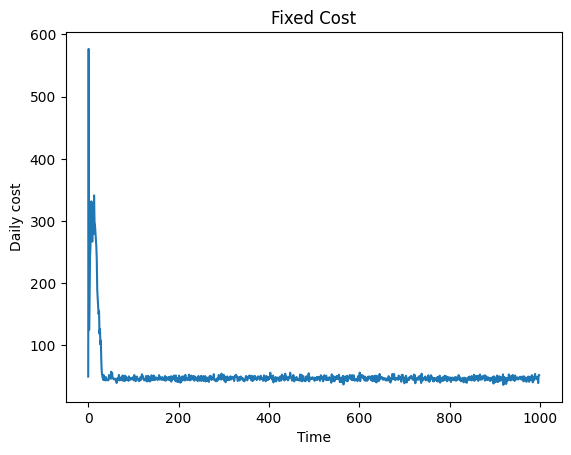

In [6]:
# Plot RL
for rl_agent in rl_agent_list:
    avg_daily_costs = [sum(daily_cost) / n for daily_cost in zip(*rl_agent_costs[rl_agent])]
    plt.plot(avg_daily_costs)
    plt.title(rl_agent)
    plt.xlabel('Daily cost')
    plt.ylabel('Time')
    plt.show()

# Plot s-S
avg_daily_costs = [sum(daily_cost) / n for daily_cost in zip(*policy_fixed_costs)]
plt.plot(avg_daily_costs)
plt.title('Fixed Cost')
plt.xlabel('Time')
plt.ylabel('Daily cost')
plt.show()

In [7]:
a2c_mlp_warmup = 150
dqn_mlp_warmup = 220
ppo_mlp_warmup = 150
fixed___warmup = 100